In [1]:
using Distributions
using RCall
using Roots
using StatsFuns

safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

function Delta(a, b, c, d; ρ=1)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    isinf(ρ) ? typeof(ω)(-c) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    RRhat = riskratiohat(a, b, c, d)
    if a == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif c == 0
        [exp(find_zero(f, 0.0)), Inf]
    elseif b == 0
        [0.0, exp(find_zero(f, log(2RRhat)))]
    elseif d == 0
        [exp(find_zero(f, log(RRhat/2))), Inf]
    else
        ρ_L, ρ_U = RRhat/2, 2RRhat
        [exp(find_zero(f, log(ρ_L))), exp(find_zero(f, log(ρ_U)))]
    end
end

confint_rr_pearson_chisq (generic function with 1 method)

In [2]:
R"""fisher.test(matrix(c(16, 4, 4, 6), 2, 2, byrow=T))"""

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  matrix(c(16, 4, 4, 6), 2, 2, byrow = T)
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



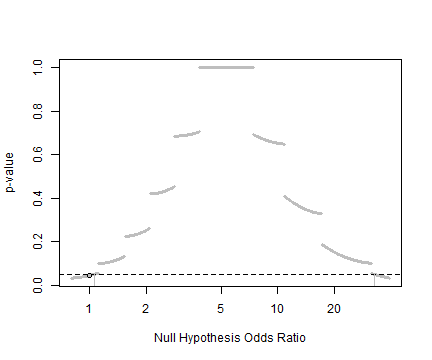

RObject{VecSxp}

	Two-sided Fisher's Exact Test (usual method using minimum likelihood)

data:  matrix(c(16, 4, 4, 6), 2, 2, byrow = T)
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  1.0549 32.6994
sample estimates:
odds ratio 
  5.585888 



In [3]:
R"""exact2x2::exact2x2(matrix(c(16, 4, 4, 6), 2, 2, byrow=T), plot=T)"""

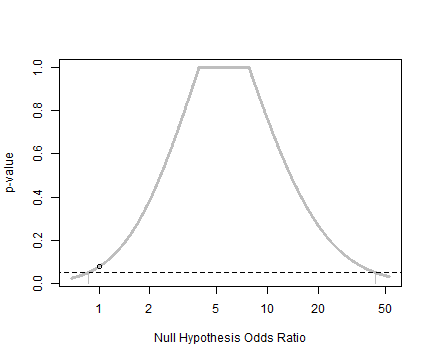

RObject{VecSxp}

	Central Fisher's Exact Test

data:  matrix(c(16, 4, 4, 6), 2, 2, byrow = T)
p-value = 0.07742
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



In [4]:
R"""exact2x2::exact2x2(matrix(c(16, 4, 4, 6), 2, 2, byrow=T), tsmethod="central", plot=T)"""

In [5]:
R"""epiR::epi.2by2(matrix(c(16, 4, 4, 6), 2, 2, byrow=T), digits=4)"""

RObject{VecSxp}
             Outcome +    Outcome -      Total        Inc risk *        Odds
Exposed +           16            4         20              80.0       4.000
Exposed -            4            6         10              40.0       0.667
Total               20           10         30              66.7       2.000

Point estimates and 95% CIs:
-------------------------------------------------------------------
Inc risk ratio                                 2.0000 (0.9076, 4.4072)
Odds ratio                                     6.0000 (1.1254, 31.9892)
Attrib risk in the exposed *                   40.0000 (4.9391, 75.0609)
Attrib fraction in the exposed (%)            50.0000 (-10.1794, 77.3097)
Attrib risk in the population *                26.6667 (-8.0681, 61.4014)
Attrib fraction in the population (%)         40.0000 (-13.8027, 68.3663)
-------------------------------------------------------------------
Yates corrected chi2 test that OR = 1: chi2(1) = 3.169 Pr>chi2 = 0.075
F

In [6]:
@show confint_rr_wald(16, 4, 4, 6);
@show confint_or_wald(16, 4, 4, 6);
@show confint_rr_pearson_chisq(16, 4, 4, 6);
@show confint_or_pearson_chisq(16, 4, 4, 6);

confint_rr_wald(16, 4, 4, 6) = [0.9076108600427952, 4.407175118873516]
confint_or_wald(16, 4, 4, 6) = [1.1253809473171112, 31.989167833188734]
confint_rr_pearson_chisq(16, 4, 4, 6) = [1.0640380701223051, 4.855065400672167]
confint_or_pearson_chisq(16, 4, 4, 6) = [1.1911176901272547, 30.49633585876287]


In [7]:
@show pvalue_rr_wald(16, 4, 4, 6);
@show pvalue_or_wald(16, 4, 4, 6);
@show pvalue_rr_pearson_chisq(16, 4, 4, 6);
@show pvalue_or_pearson_chisq(16, 4, 4, 6);
@show pvalue_or_pearson_chisq(16, 4, 4, 6; correction=0.5);

pvalue_rr_wald(16, 4, 4, 6) = 0.08552581801836596
pvalue_or_wald(16, 4, 4, 6) = 0.0358791966995754
pvalue_rr_pearson_chisq(16, 4, 4, 6) = 0.028459736916310572
pvalue_or_pearson_chisq(16, 4, 4, 6) = 0.028459736916310572
pvalue_or_pearson_chisq(16, 4, 4, 6; correction = 0.5) = 0.07505987281783365
